## Welcome!

In notebook we calculate Stored Carbon from an ISRIC dataset, more specifically the ISRIC-WISE Harmonized Global Soil Profile Dataset v3.1 available here: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a351682c-330a-4995-a5a1-57ad160e621c"

The dataset (in MS Access format) was downloaded and split into .csv files, available in a .zip here:

https://drive.google.com/file/d/1wuhyplJ7klD4hV7BsAGSalnXjc5a4GK4/view?usp=sharing

In [2]:
using Pkg

In [3]:
Pkg.add(["Plots","DataFrames", "CSV", "Query", "StatsBase", "DataInterpolations"])

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [5]:
Pkg.precompile()

Precompiling project...


In [6]:
using Plots, DataFrames, CSV, Query, StatsBase, DataInterpolations

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


Let's import the soil horizon data:

In [7]:
df_horizon = CSV.read(download("https://drive.google.com/uc?export=download&id=1dAHPZfm8KIXC9qVks-owkD0LYbZjPpIM"), DataFrame)

┌ Warning: thread = 1 warning: only found 30 / 31 columns around data row: 47834. Filling remaining columns with `missing`
└ @ CSV /Users/Daniele/.julia/packages/CSV/la2cd/src/file.jl:603


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,MCOLOR,DCOLOR,ORGC,TOTN,CACO3
,String,Int64,String?,Int64,Int64,String?,String?,String?,String?,String?
1,AF0001,1,missing,0,15,10YR4/3,10YR4/2,"7,6","0,6",93
2,AF0001,2,missing,15,60,10YR5/3,10YR5/2,"2,3","0,3",177
3,AF0001,3,missing,60,150,10YR5/3,missing,"0,9","0,3",182
4,AF0002,1,missing,0,20,10YR4/2,missing,"12,8","0,9",191
5,AF0002,2,missing,20,60,10YR4/2,missing,6,"0,6",192
6,AF0002,3,missing,60,110,10YR4/3,missing,"3,9","0,6",203
7,AF0002,4,missing,110,170,10YR4/3,missing,"2,7",missing,240
8,AF0003,1,A,0,20,10YR4/2,missing,"5,9","0,7",169
9,AF0003,2,Bg,20,50,10YR4/2,missing,"2,4","0,4",138


Some cleaning is necessary:

In [8]:
filt_hz = df_horizon[:,[:WISE3_ID,:HONU,:DESIG,:TOPDEP,:BOTDEP,:ORGC,:BULKDENS]]

dropmissing!(filt_hz,[:BULKDENS,:ORGC,:DESIG])	

#BULKDENS and ORGC are still strings
filt_hz.BULKDENS = tryparse.(Float64,replace.(filt_hz.BULKDENS,','=>'.'))
filt_hz.ORGC = tryparse.(Float64,replace.(filt_hz.ORGC,','=>'.'))

filt_hz


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String,Int64,Int64,Float64,Float64
1,AL0007,1,Ap,0,25,9.8,1.64
2,AL0007,2,AB,25,49,7.8,1.62
3,AL0007,3,Bw1,49,83,5.9,1.57
4,AL0007,4,Bw2,83,116,6.9,1.63
5,AL0007,5,2C1,116,147,4.6,1.56
6,AL0007,6,2C2,147,160,4.6,1.45
7,AL0008,1,Ap-,0,17,11.5,1.61
8,AL0008,2,Bw1,17,38,8.1,1.55
9,AL0008,3,2Bw2,38,66,1.7,1.18


Let's take a peek at ORGC and BULKDENS for the first profile:

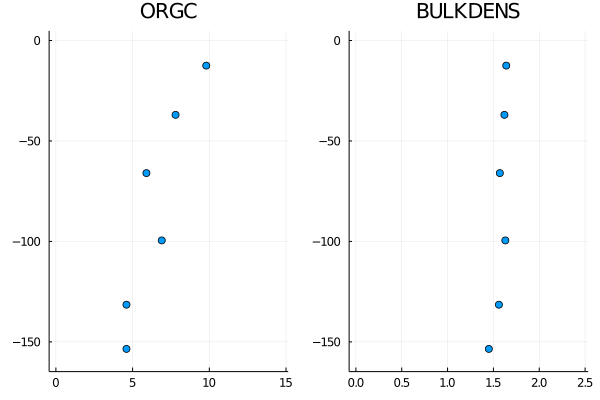

In [9]:
begin
profile = filt_hz[filt_hz.WISE3_ID.=="AL0007",:]

#top and bottom for each section
td = profile.TOPDEP
bp = profile.BOTDEP

#values
blk = profile.BULKDENS
orgc = profile.ORGC	

#plotting utilities
y_mid = (td .+ bp)./2 #mid-depth for each measurement section within a profile
y_lim = [-maximum(bp),0]
x_lim_orgc = [0,maximum(orgc)*1.5]
x_lim_blk = [0,maximum(blk)*1.5]


s1 = scatter(orgc,-y_mid,legend=nothing,xlim=x_lim_orgc, ylim=y_lim, title="ORGC")
s2 = scatter(blk,-y_mid,legend=nothing,xlim=x_lim_blk, ylim=y_lim, title="BULKDENS")

plot(s1,s2)

end

As measurements represent an average the whole profile section, I'm using a constant interpolation between TOP and BOT depth of each section:

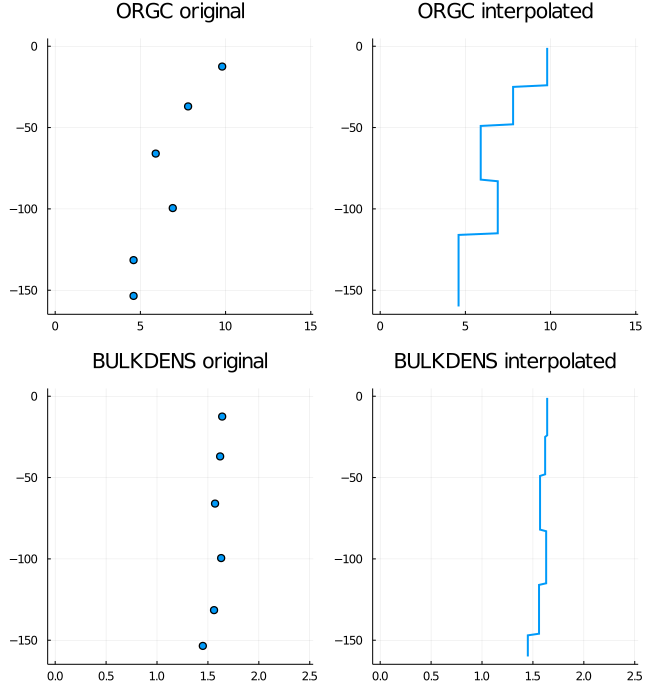

In [10]:

#merge TOP and BOT depth vectors	
y_sections = sort!(cat(td,bp, dims=1))
y_linear = [i for i in 1:maximum(bp)]

#duplicate ORGC readings at each TOP/BOT end (for later interpolation)
orgc_ends = [orgc[Int(ceil(i/2))] for i in 1:length(orgc)*2] 
blk_ends = [blk[Int(ceil(i/2))] for i in 1:length(blk)*2] 

#interpolation up to SOLDEP (= Max BOTDEP for profile)
orgc_interp = ConstantInterpolation(orgc_ends,y_sections)
orgc_calc = orgc_interp.(y_linear)

blk_interp = ConstantInterpolation(blk_ends,y_sections)
blk_calc = blk_interp.(y_linear)
	
# ORGC plot, original values
p_orgc_or=scatter(orgc,-y_mid, legend=nothing, xlim=x_lim_orgc, ylim=y_lim, title="ORGC original")

# ORGC plot, interpolated values
p_orgc_in = plot(orgc_calc,-y_linear, legend=nothing, xlim=x_lim_orgc, linewidth=2, ylim=y_lim, title="ORGC interpolated")

# BULKDENS plot, original values
p_blk_or =scatter(blk,-y_mid, legend=nothing, xlim=x_lim_blk, ylim=y_lim, title="BULKDENS original")

# BULKDENS plot, interpolated values
p_blk_in = plot(blk_calc,-y_linear, legend=nothing, xlim=x_lim_blk, linewidth=2, ylim=y_lim, title="BULKDENS interpolated")


plot(p_orgc_or, p_orgc_in, p_blk_or, p_blk_in, layout=4, size=(650,700))


md"As we have (interpolated) BULKDENS and ORGC values for each 1cm slice of soil, from 1cm to SOLDEP of depth, we can now calculate total ORGC stored in 1m²xSOLDEP of soil.

Given the dataset, we'll have to calculate storage as:\
BULKDENS [g / cm³] x AREA [m²] x ORGC [g / Kg] down to SOLDEP, 1cm at a time

The result will be in Kgs."

Generalizing the approach above, I define a function that I can call on each profile:

In [11]:
function orgc_storage(profile) 

top = profile.TOPDEP
bot = profile.BOTDEP

blk_temp = profile.BULKDENS
orgc_temp = profile.ORGC

soldep = maximum(bot) #[cm]
y_linear = [i for i in 1:soldep]

#doubled vectors for use in interpolation
y_sections = sort!(cat(top,bot,dims=1)) 	
orgc = [orgc_temp[Int(ceil(i/2))] for i in 1:length(orgc_temp)*2] 
blk = [blk_temp[Int(ceil(i/2))] for i in 1:length(blk_temp)*2] 


#interpolation
orgc_interp = ConstantInterpolation(orgc,y_sections)
orgc_values = orgc_interp.(y_linear)

blk_interp = ConstantInterpolation(blk,y_sections)
blk_values = blk_interp.(y_linear)

#ORGC mass calculation	(1cm x 1m² slices)
stored_orgc_profile = [blk_values[i]*orgc_values[i]*(1/100) for i in y_linear]

return sum(stored_orgc_profile) 

end


orgc_storage (generic function with 1 method)

I call the function on each profile in the dataset, and order the result:

In [12]:
soil_profiles = unique(filt_hz.WISE3_ID)
orgc_mass_dict = Dict()

for profile in soil_profiles
    orgc_mass_dict[profile] = orgc_storage(filt_hz[filt_hz.WISE3_ID.==profile,:])
end

Turn results stored in Dict to DF

In [13]:
stored_ORGC = sort!(DataFrame(WISE3_ID = String.(keys(orgc_mass_dict)), 
                              STORED_ORGC = Float64.(values(orgc_mass_dict))))

,WISE3_ID,STORED_ORGC
,String,Float64
1,AL0007,16.9092
2,AL0008,6.62788
3,AL0009,10.0614
4,AL0010,15.9469
5,AL0011,19.3211
6,AL0012,12.7393
7,AL0013,14.1908
8,AL0014,13.491
9,AL0015,23.4659


Let's enrich the data with extra information for each profile:

In [14]:
df_site = CSV.read(download("https://drive.google.com/uc?export=download&id=1mki-fWQDwmoimO87TxboJJA69usr66P_"), DataFrame)

,WISE3_id,ISO,DESCR,DATEYR,DATEMON,SOLDEP,HORNUM,FAO_90,PHA_90,FAO_74
,String,String,Int64,Int64?,Int64?,Int64,Int64,String,String?,String?
1,AF0001,AF,3,1962,missing,150,3,CLl,missing,Bk
2,AF0002,AF,3,1962,missing,170,4,FLc,missing,Jc
3,AF0003,AF,3,1962,missing,110,3,FLc,missing,Jc
4,AF0004,AF,3,1962,missing,270,6,SCg,missing,Zo
5,AF0005,AF,3,1962,missing,190,6,SCk,missing,Zo
6,AL0001,AL,4,1981,9,94,4,LVk,missing,Lk
7,AL0002,AL,4,1983,9,87,3,LPk,missing,Be
8,AL0003,AL,4,1985,12,85,3,LVf,missing,Lf
9,AL0004,AL,4,1991,11,120,6,CMc,missing,Bk


Pick only relevant columns from the SITE dataset:

In [15]:
filt_site = df_site[:,[:WISE3_id, :DATEYR, :SOLDEP, :LONDD, :LATDD]]

    rename!(filt_site,:WISE3_id => :WISE3_ID)

    dropmissing!(filt_site,[:LONDD,:LATDD])	

    filt_site.LONDD = tryparse.(Float64,replace.(filt_site.LONDD,','=>'.'))
    filt_site.LATDD = tryparse.(Float64,replace.(filt_site.LATDD,','=>'.'))

    filt_site

,WISE3_ID,DATEYR,SOLDEP,LONDD,LATDD
,String,Int64?,Int64,Float64,Float64
1,AF0001,1962,150,69.1667,34.5
2,AF0002,1962,170,69.1667,34.5
3,AF0003,1962,110,69.1667,34.5
4,AF0004,1962,270,61.4333,34.3333
5,AF0005,1962,190,62.1333,32.3833
6,AL0001,1981,94,20.75,40.6167
7,AL0002,1983,87,20.3006,39.635
8,AL0003,1985,85,20.3861,42.2222
9,AL0004,1991,120,19.5611,41.0778


Let's join the computed results with data from SITE:

In [17]:
stored_ORGC_ds = innerjoin(stored_ORGC, filt_site, on = :WISE3_ID)

,WISE3_ID,STORED_ORGC,DATEYR,SOLDEP,LONDD,LATDD
,String,Float64,Int64?,Int64,Float64,Float64
1,AL0007,16.9092,1994,160,19.9956,41.0694
2,AL0008,6.62788,1994,100,20.6472,40.215
3,AL0009,10.0614,1994,110,20.7844,40.6372
4,AL0010,15.9469,1994,110,19.4836,40.3453
5,AL0011,19.3211,1994,130,19.7703,41.3778
6,AL0012,12.7393,1994,173,20.9589,40.6553
7,AL0013,14.1908,1994,180,20.7325,40.5644
8,AL0014,13.491,1994,130,20.4064,41.6928
9,AL0015,23.4659,1994,180,19.7625,41.37


The results can be accessed here:

https://drive.google.com/file/d/1FVJsZKdjQznR52ly6yj4-kBMB1s3Rrmi/view?usp=sharing